In [140]:
#!pip install wordcloud
#!pip install gliner-spacy
#!pip install pillow==9.5

In [141]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score, roc_curve, accuracy_score
nltk.download('punkt')
#import spacy
#from spacy.lang.en import English
#from spacy.pipeline import EntityRuler
#from gliner_spacy.pipeline import GlinerSpacy

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/angelicaspratley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Read in the sample dataframe has 100,000 rows 

### Column Info from Stakeholder Documentation

**Name**:  a party name that appears in one or more cases

**Extra Info:** some optional “extra info” about the party that may be listed on the docket

**Nature-of-suit subtype:** specifiying the type of case to which this party belongs (which
can also be diagnostic in certain situations)

**UCIDs:** case IDs containing parties matching the description given in this row (in
case you want to look at the underlying case files that contain a certain party)

### Exploratory Data Analysis 

In [142]:
samp_df = pd.read_csv('./data/samp_df_scales_v1.csv')

In [143]:
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids
0,Darren Bowens,NaN,crim,['mdd;;1:17-cr-00426']
1,Officer Aaron Collier,CVPD,habeas_corpus,['arwd;;6:16-cv-06006']
2,John Doe No. 2,"Correctional Sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929']
3,Pearlie M Harris,NaN,real_property,['ilnd;;1:04-cv-01953']
4,DANIEL RANDALL,NaN,civil_rights,['paed;;2:13-cv-03864']


In [144]:
#One missing 'name' can drop later
samp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   name                 99999 non-null   object
 1   extra_info           29192 non-null   object
 2   nature_suit_subtype  100000 non-null  object
 3   ucids                100000 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB


<AxesSubplot:xlabel='nature_suit_subtype', ylabel='count'>

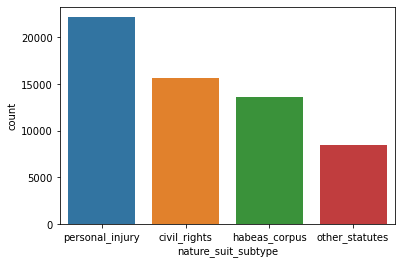

In [145]:
top_categories = samp_df['nature_suit_subtype'].value_counts().nlargest(4).index.tolist()
filtered_df = samp_df[samp_df['nature_suit_subtype'].isin(top_categories)]
sns.countplot(x=filtered_df['nature_suit_subtype'], order=top_categories)
#alot of personal injury suits can be govt or personal though 

In [146]:
### Just checking for duplicates across three features the ucids store the unique case info there are no dups
duplicates = samp_df[samp_df.duplicated(subset=['name', 'extra_info', 'ucids'], keep=False)]
duplicates.shape

(0, 4)

In [147]:
##Get tokens to see how long the names are and if any standout 

def tokenize_column(df, column_name):
    # Define a tokenizer function
    def tokenizer(text):
        if pd.isna(text):
            return []
        tokens = word_tokenize(text)
        # Convert each token to lowercase
        tokens_lower = [token.lower() for token in tokens]
        return tokens_lower
    df[column_name + '_tokenized'] = df[column_name].apply(tokenizer)

    return df

In [148]:
#lowercase/tokenize name using functions above
samp_df = tokenize_column(samp_df, 'name')

In [149]:
#lowercase/tokenize 'extra_info' column as well 
samp_df = tokenize_column(samp_df, 'extra_info')

In [150]:
#sanity check
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized
0,Darren Bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",[]
1,Officer Aaron Collier,CVPD,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd]
2,John Doe No. 2,"Correctional Sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]","[correctional, sergeant, ,, in, individual, ca..."
3,Pearlie M Harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",[]
4,DANIEL RANDALL,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",[]


In [151]:
#Create a feature that is summing up all the tokens 
samp_df['token_count'] = samp_df['name_tokenized'].apply(lambda x: len(x))

In [152]:
samp_df['token_count'].value_counts().sort_index()
#tokens from 0 to 46

0         1
1      4398
2     45140
3     26427
4      7800
5      7113
6      4860
7      1904
8       970
9       482
10      261
11      164
12      102
13       81
14       69
15       39
16       31
17       27
18       20
19       15
20       10
21       14
22        7
23       11
24        4
25        5
26        3
27        3
28        7
29        7
30        3
31        5
32        1
34        1
37        3
38        1
39        1
40        2
41        1
42        2
43        1
44        1
45        1
46        2
Name: token_count, dtype: int64

In [153]:
samp_df.describe()
#outlier Q3 + 1.5*IQR =4.5 ~ 5
#zone in on the tail starting at 20 tokens 

,token_count
count,100000.000000
mean,3.077600
std,1.864155
min,0.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,46.000000


In [154]:
big_tokens = samp_df.loc[samp_df['token_count']>=20]
big_tokens
#96 of them

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count
1293,"Unknown Stockholders, Officers, Successors, Tr...",NaN,real_property,['ned;;8:17-cv-00346'],"[unknown, stockholders, ,, officers, ,, succes...",[],23
2303,"IBEW LOCAL 102 WELFARE, PENSION ANNUITY AND JO...",NaN,labor,['njd;;2:17-cv-02689'],"[ibew, local, 102, welfare, ,, pension, annuit...",[],20
3587,"Deutsche Bank National Trust Company, as Trust...",NaN,contract,['ilnd;;1:06-cv-01733'],"[deutsche, bank, national, trust, company, ,, ...",[],31
4090,Fifteen Thousand Seven Hundred Sixty-One and N...,"Registered to Jay Sharon, and All Proceeds Tra...",forfeiture/penalty,['nyed;;1:16-cv-04914'],"[fifteen, thousand, seven, hundred, sixty-one,...","[registered, to, jay, sharon, ,, and, all, pro...",37
4694,"Harrington and Richardson Arms, Sportsman, Dou...",NaN,forfeiture/penalty,['ilcd;;4:17-cv-04087'],"[harrington, and, richardson, arms, ,, sportsm...",[],20
...,...,...,...,...,...,...,...
98309,"Electrolux Home Products, Inc. f/k/a White Con...",NaN,personal_injury,"['mad;;1:16-cv-11614', 'mad;;1:16-cv-11614', '...","[electrolux, home, products, ,, inc., f/k/a, w...",[],21
98579,"TEVA WOMEN'S HEALTH INC., INDIVIDUALLY, AND AS...",NaN,personal_injury,"['paed;;2:21-cv-00075', 'paed;;2:20-cv-05711',...","[teva, women, 's, health, inc., ,, individuall...",[],28
98666,THE LABORERS' DISTRICT COUNCIL OF THE METROPOL...,RYAN BOYER AS TRUSTEE AD LITEM,labor,"['paed;;2:13-cv-03552', 'paed;;2:11-cv-04440',...","[the, laborers, ', district, council, of, the,...","[ryan, boyer, as, trustee, ad, litem]",20
98897,"United Steel, Paper, and Forestry, Rubber, Man...","USW Local #7-507,",contract,['ilnd;;1:07-cv-05410'],"[united, steel, ,, paper, ,, and, forestry, ,,...","[usw, local, #, 7-507, ,]",21


In [155]:
#search for john does can be govt or person 
result_johndoe = samp_df[samp_df['name_tokenized'].apply(lambda x: 'john' in x and 'doe' in x)]

In [156]:
result_johndoe.tail(50)

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count
90773,M.D. John Doe,#2 attending emergency room physician at Freep...,habeas_corpus,['ilnd;;3:06-cv-50144'],"[m.d, ., john, doe]","[#, 2, attending, emergency, room, physician, ...",4
91244,John Doe Lincoln County Sheriff,NaN,habeas_corpus,['wiwd;;3:17-cv-00309'],"[john, doe, lincoln, county, sheriff]",[],5
91329,John Doe,Correctional Officer at Jacksonville Correctio...,habeas_corpus,"['ilcd;;3:16-cv-03140', 'ilcd;;3:17-cv-03040']","[john, doe]","[correctional, officer, at, jacksonville, corr...",2
91360,John Doe #2,individual official capacity,habeas_corpus,['ilnd;;1:14-cv-08791'],"[john, doe, #, 2]","[individual, official, capacity]",4
91396,JOHN DOE SUBSCRIBER ASSIGNED IP ADDRESS 108.52...,NaN,property_rights,['paed;;2:20-cv-05130'],"[john, doe, subscriber, assigned, ip, address,...",[],7
91597,John Doe,Executive Director of Cook County Department o...,habeas_corpus,['ilnd;;1:15-cv-02507'],"[john, doe]","[executive, director, of, cook, county, depart...",2
91664,STATE POLICE OFFICER JOHN DOE,NOS. 1 AND 2,personal_injury,['paed;;2:04-cv-21202'],"[state, police, officer, john, doe]","[nos, ., 1, and, 2]",5
91746,John Doe Albaladejo-Santiago,(the Estate of Jose Albaladejo-Santiago),real_property,['prd;;3:16-cv-02612'],"[john, doe, albaladejo-santiago]","[(, the, estate, of, jose, albaladejo-santiago...",3
91815,John Doe No. 2,Inmate Trustee,civil_rights,['tned;;3:17-cv-00401'],"[john, doe, no, ., 2]","[inmate, trustee]",5
91915,John Doe,"Dentist, individual capacity",habeas_corpus,['ilnd;;1:15-cv-07943'],"[john, doe]","[dentist, ,, individual, capacity]",2


In [157]:
#580 John Does -- do they have 'extra_info' that may help? 
result_johndoe.shape

(580, 7)

In [158]:
#Over 60% of John Does have extra_info so we can use this column to throw them into a group
result_johndoe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 580 entries, 2 to 99568
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   name                  580 non-null    object
 1   extra_info            364 non-null    object
 2   nature_suit_subtype   580 non-null    object
 3   ucids                 580 non-null    object
 4   name_tokenized        580 non-null    object
 5   extra_info_tokenized  580 non-null    object
 6   token_count           580 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 36.2+ KB


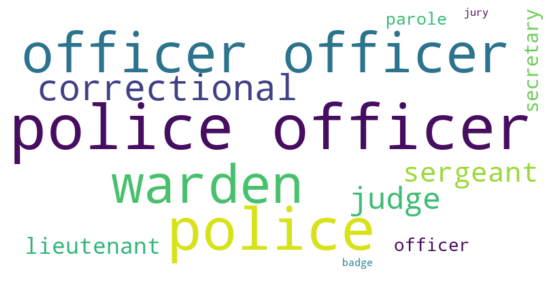

In [159]:
#WordCloud total dataframe 
tokens_of_interest = ['officer', 'secretary', 'correctional', 'district attorney', 'd.a.', 'warden', 'police', 
                      'judge', 'district attorney\'s', 'p.o.', 'jury', 'badge', 'sergeant', 'lieutenant', 'parole']

filtered_tokens = [word for sublist in samp_df['name_tokenized'] for word in sublist if word in tokens_of_interest]


text = ' '.join(filtered_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

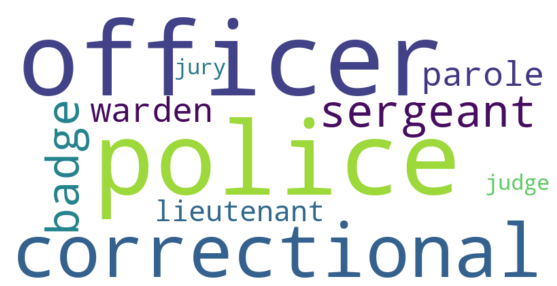

In [160]:
#Wordcloud for John Does for extra_info column 

tokens_of_interest = ['officer', 'secretary', 'correctional', 'district attorney', 'd.a.', 'warden', 'police', 
                      'judge', 'district attorney\'s', 'p.o.', 'jury', 'badge', 'sergeant', 'lieutenant', 'parole']

filtered_tokens = [word for sublist in result_johndoe['extra_info_tokenized'] for word in sublist if word in tokens_of_interest]


text = ' '.join(filtered_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#word cloud has some formal titles in the 'extra_info' columns for john does so may can classify those as govt
#want to err on overly classifying government per stakeholder request 

### Goal is create a target (person/govt) then classify each row as non_govt (person) vs govt this is stakeholder definition of government:

"We are interested in the parties (i.e. people or groups involved in litigation) listed on each
docket sheet. Specifically, we hope to develop a method for determining whether a given party
falls into a category we’re calling “government entities.” For our purposes, a government entity is
either a literal governing body (“United States,” “City of Chicago”), a subsidiary or affiliate of
a governing body (“U.S. Department of Education,” “Chicago Police Dept”), or a person
working for one of the above (“Secretary of Education Miguel Cardona,” “Officer Joe Smith”)"

**note it is better to overly classify it as government if there is a suspicion that it may be govt**

**Need some rules to help with this--brainstorming -- all rules should be 'True' if it applies to government entities**


1. Contains u . s .
2. Contains 'department of'
3. Contains the word 'city of' (saw some examples with **indiv of estate** so added the word 'city' in front of this for narrower scope)
4. DOES NOT Contains 'LLC' (indiv business)
5. Formal Titles in NAME field ('Secretary, Officer, Judge, d.a.)
6. DOES NOT have Word single letter than word (most likely individuals)?
7. If it contains Dept (rule 2 won't capture this)
8. Two or Three tokens (most likely indivdual if other rules don't output govt)
9. If extra_info DOES NOT contain 'indiv'
10. extra_info contains formal titles
11. DOES NOT have llc (without the periods)
12. Contains inc. (individual?) 




### Create new features based on regex pattern (exploration purposes)

In [161]:
#drop that one missing 'name' value found above
samp_df = samp_df.dropna(subset='name')

In [162]:
#make columns lowercase
samp_df['name'] = samp_df['name'].str.lower()
samp_df['extra_info'] = samp_df['extra_info'].str.lower()

In [163]:
#Matches rule 1 above -- contains u.s.

regex1 =  r'u\.s\.'
samp_df = samp_df.assign(let_period_let_regex=samp_df['name'].str.contains(regex1))

In [164]:
#Sanity Check
samp_df['let_period_let_regex'].value_counts()
samp_df[samp_df['let_period_let_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex
979,pentax u.s.a. inc.,NaN,other_statutes,['ilnd;;1:07-cv-06458'],"[pentax, u.s.a., inc, .]",[],4,True
1400,u.s. attorney,NaN,civil_rights,"['ohnd;;3:17-cv-00398', 'hid;;1:17-cv-00262', ...","[u.s., attorney]",[],2,True
1474,u.s. bank national association,as indentured trustee for sasco mortgage loan ...,real_property,['txsd;;3:17-cv-00215'],"[u.s., bank, national, association]","[as, indentured, trustee, for, sasco, mortgage...",4,True
1675,u.s. court of appeals of the third circuit,NaN,civil_rights,['paed;;2:16-cv-06153'],"[u.s., court, of, appeals, of, the, third, cir...",[],8,True
1701,u.s. attorney general .,NaN,habeas_corpus,['paed;;2:05-cv-02451'],"[u.s., attorney, general, .]",[],4,True
...,...,...,...,...,...,...,...,...
98096,u.s. ice field office director for the miami f...,"marc j. moore, field operation director",habeas_corpus,"['gasd;;5:17-cv-00160', 'flsd;;1:17-cv-24039']","[u.s., ice, field, office, director, for, the,...","[marc, j., moore, ,, field, operation, director]",10,True
98764,u.s. department of homeland security,(dhs),other_statutes,['gand;;1:17-cv-00353'],"[u.s., department, of, homeland, security]","[(, dhs, )]",5,True
99316,u.s. parole commissioner,et al.,habeas_corpus,['paed;;2:13-cv-03317'],"[u.s., parole, commissioner]","[et, al, .]",3,True
99658,white house u.s.a.,NaN,civil_rights,['vaed;;2:17-cv-00220'],"[white, house, u.s.a, .]",[],4,True


In [165]:
#Matches rule 2 above -- contains department of

regex2 = r'\bdepartment\s+of\b'
samp_df = samp_df.assign(dept_of_regex=samp_df['name'].str.contains(regex2))

In [166]:
samp_df['dept_of_regex'].value_counts()
samp_df[samp_df['dept_of_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex
232,wyoming department of corrections state penite...,in his official capacity\nalso known as\nethan...,habeas_corpus,['wyd;;2:17-cv-00153'],"[wyoming, department, of, corrections, state, ...","[in, his, official, capacity, also, known, as,...",8,False,True
491,somerville department of public works,NaN,civil_rights,['mad;;1:17-cv-12071'],"[somerville, department, of, public, works]",[],5,False,True
654,wyoming department of corrections state penite...,in his/her official capacity\nalso known as\ns...,habeas_corpus,['wyd;;1:16-cv-00244'],"[wyoming, department, of, corrections, state, ...","[in, his/her, official, capacity, also, known,...",8,False,True
990,sacramento department of justice,NaN,civil_rights,['caed;;2:16-cv-03029'],"[sacramento, department, of, justice]",[],4,False,True
1644,united states department of air force,NaN,civil_rights,['nmd;;1:17-cv-01272'],"[united, states, department, of, air, force]",[],6,False,True
...,...,...,...,...,...,...,...,...,...
97729,united states department of health and human s...,NaN,personal_injury,"['txsd;;3:20-cv-00058', 'nynd;;1:16-cv-01399',...","[united, states, department, of, health, and, ...",[],8,False,True
98247,department of homeland security,united states immigration and customs enforcement,civil_rights,['nvd;;3:17-cv-00257'],"[department, of, homeland, security]","[united, states, immigration, and, customs, en...",4,False,True
98726,south carolina department of motor vehicles,NaN,civil_rights,"['scd;;3:17-cv-00217', 'scd;;3:17-cv-02224', '...","[south, carolina, department, of, motor, vehic...",[],6,False,True
98764,u.s. department of homeland security,(dhs),other_statutes,['gand;;1:17-cv-00353'],"[u.s., department, of, homeland, security]","[(, dhs, )]",5,True,True


In [167]:
#Matches rule 3 above -- contains city of

regex3 = r'\bcity of\b'
samp_df = samp_df.assign(cityof_regex=samp_df['name'].str.contains(regex3))

In [168]:
#Sanity Check
samp_df[samp_df['cityof_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex
189,"montgomery, city of",NaN,civil_rights,"['mied;;5:17-cv-12920', 'nvd;;3:17-cv-00074', ...","[montgomery, ,, city, of]",[],4,False,False,True
380,city of chicago,as a corporation,civil_rights,['ilnd;;1:06-cv-03433'],"[city, of, chicago]","[as, a, corporation]",3,False,False,True
504,city of philadelphia police officer john doe 1,individually and as a police officer for the c...,habeas_corpus,['paed;;2:19-cv-04754'],"[city, of, philadelphia, police, officer, john...","[individually, and, as, a, police, officer, fo...",8,False,False,True
514,city of santa monica,a municipal corporation,other_statutes,['cacd;;2:16-cv-04481'],"[city, of, santa, monica]","[a, municipal, corporation]",4,False,False,True
679,"city of new albany, indiana",NaN,civil_rights,['insd;;4:17-cv-00185'],"[city, of, new, albany, ,, indiana]",[],6,False,False,True
...,...,...,...,...,...,...,...,...,...,...
99277,city of wilkes-barre,NaN,civil_rights,['pamd;;3:17-cv-00239'],"[city, of, wilkes-barre]",[],3,False,False,True
99584,"ashville, city of",NaN,civil_rights,['alnd;;4:21-cv-01502'],"[ashville, ,, city, of]",[],4,False,False,True
99627,city of espanola,a municipal corporation,personal_injury,['nmd;;1:17-cv-00648'],"[city, of, espanola]","[a, municipal, corporation]",3,False,False,True
99790,frisco city of,NaN,contract,['txed;;4:17-cv-00311'],"[frisco, city, of]",[],3,False,False,True


In [169]:
#Matches rule 4 above -- does NOT contain l.l.c
regex4 = r'^(?!.*l\.l\.c\.).*$'
samp_df = samp_df.assign(llc_regex=samp_df['name'].str.contains(regex4))

In [170]:
#Sanity Check
samp_df[samp_df['llc_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",[],2,False,False,False,True
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,False,False,False,True
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]","[correctional, sergeant, ,, in, individual, ca...",5,False,False,False,True
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",[],3,False,False,False,True
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",[],2,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
99995,creighton e. miller,administrator of the estate of (deceased) jame...,personal_injury,['paed;;2:11-cv-34941'],"[creighton, e., miller]","[administrator, of, the, estate, of, (, deceas...",3,False,False,False,True
99996,sinohe antonio araujo meza,also known as\ncarrera,crim,['nysd;;1:16-cr-00680'],"[sinohe, antonio, araujo, meza]","[also, known, as, carrera]",4,False,False,False,True
99997,ruthie myers,NaN,civil_rights,['mowd;;5:16-cv-06121'],"[ruthie, myers]",[],2,False,False,False,True
99998,gerald f. morris,NaN,personal_injury,"['paed;;2:13-cv-06591', 'paed;;2:13-cv-06591',...","[gerald, f., morris]",[],3,False,False,False,True


In [171]:
#Matches rule 5 above -- matches a formal govt title in 'name' field
regex5 = r'(?:officer|secretary|correctional|district attorney|d.a.|warden|police|judge|district attorney\'s|p.o.|jury|badge|sergeant|lieutenant|parole)\s+\w+'
samp_df = samp_df.assign(formal_name_regex=samp_df['name'].str.contains(regex5))

In [172]:
#Sanity Check
samp_df[samp_df['formal_name_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,False,False,False,True,True
11,real property located at 2255 elkhorn boulevar...,apn: 207-0202-046-0000,forfeiture/penalty,['caed;;2:16-cv-02394'],"[real, property, located, at, 2255, elkhorn, b...","[apn, :, 207-0202-046-0000]",12,False,False,False,True,True
61,officer robert otto,NaN,civil_rights,['paed;;2:17-cv-05189'],"[officer, robert, otto]",[],3,False,False,False,True,True
63,police officer david killingsworth,NaN,civil_rights,['paed;;2:13-cv-00256'],"[police, officer, david, killingsworth]",[],4,False,False,False,True,True
97,sergeant fnu valdez,correctional officer at estelle unit,habeas_corpus,['txwd;;5:20-cv-00769'],"[sergeant, fnu, valdez]","[correctional, officer, at, estelle, unit]",3,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
99610,"wyndham worldwide operations, inc.",NaN,labor,['gand;;1:17-cv-03680'],"[wyndham, worldwide, operations, ,, inc, .]",[],6,False,False,False,True,True
99750,sergeant smith,of division 1,habeas_corpus,['ilnd;;1:09-cv-00813'],"[sergeant, smith]","[of, division, 1]",2,False,False,False,True,True
99759,police officer david ortiz,NaN,habeas_corpus,['nysd;;7:17-cv-08886'],"[police, officer, david, ortiz]",[],4,False,False,False,True,True
99931,police officers john does 1-5,NaN,civil_rights,"['nyed;;1:16-cv-00127', 'nyed;;1:16-cv-02631',...","[police, officers, john, does, 1-5]",[],5,False,False,False,True,True


In [173]:
#Matches rule 6 above -- DOES NOT have word single letter than word

regex6 = r'^(?!\b\w+\s+[a-zA-Z]\s+\w+\b).*$'

samp_df = samp_df.assign(word_let_word_regex=samp_df['name'].str.contains(regex6))


In [174]:
samp_df[samp_df['word_let_word_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",[],2,False,False,False,True,False,True
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,False,False,False,True,True,True
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]","[correctional, sergeant, ,, in, individual, ca...",5,False,False,False,True,False,True
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",[],2,False,False,False,True,False,True
5,jennie jones-hurdlow,NaN,contract,"['azd;;4:17-cv-00288', 'azd;;4:17-cv-00288', '...","[jennie, jones-hurdlow]",[],2,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,creighton e. miller,administrator of the estate of (deceased) jame...,personal_injury,['paed;;2:11-cv-34941'],"[creighton, e., miller]","[administrator, of, the, estate, of, (, deceas...",3,False,False,False,True,False,True
99996,sinohe antonio araujo meza,also known as\ncarrera,crim,['nysd;;1:16-cr-00680'],"[sinohe, antonio, araujo, meza]","[also, known, as, carrera]",4,False,False,False,True,False,True
99997,ruthie myers,NaN,civil_rights,['mowd;;5:16-cv-06121'],"[ruthie, myers]",[],2,False,False,False,True,False,True
99998,gerald f. morris,NaN,personal_injury,"['paed;;2:13-cv-06591', 'paed;;2:13-cv-06591',...","[gerald, f., morris]",[],3,False,False,False,True,False,True


In [175]:
#Matches rule #7 -- contains dept different spelling than department 
regex8 = r'\bdept\b'

samp_df = samp_df.assign(dept_regex=samp_df['name'].str.contains(regex8))

In [176]:
samp_df[samp_df['dept_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex
206,la dept of transportation & development,NaN,personal_injury,"['lawd;;6:16-cv-01248', 'lawd;;2:16-cv-01524',...","[la, dept, of, transportation, &, development]",[],6,False,False,False,True,False,True,True
425,mailroom-r+d dept.,NaN,habeas_corpus,['ilnd;;3:20-cv-50059'],"[mailroom-r+d, dept, .]",[],3,False,False,False,True,False,True,True
781,cook county dept. of facilities management,NaN,civil_rights,['ilnd;;1:13-cv-02387'],"[cook, county, dept, ., of, facilities, manage...",[],7,False,False,False,True,False,True,True
1686,ingham county sheriff dept.,NaN,habeas_corpus,['mied;;2:17-cv-10777'],"[ingham, county, sheriff, dept, .]",[],5,False,False,False,True,False,True,True
3551,rockford police dept.,a local governmental agency,habeas_corpus,['ilnd;;3:08-cv-50272'],"[rockford, police, dept, .]","[a, local, governmental, agency]",4,False,False,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95721,u.s. dept of labor,NaN,personal_injury,['wawd;;2:17-cv-01877'],"[u.s., dept, of, labor]",[],4,True,False,False,True,False,True,True
96904,melbourne police dept,NaN,habeas_corpus,['flmd;;6:16-cv-02092'],"[melbourne, police, dept]",[],3,False,False,False,True,True,True,True
97512,sterling police dept.,NaN,habeas_corpus,['ilnd;;3:10-cv-50123'],"[sterling, police, dept, .]",[],4,False,False,False,True,True,True,True
98404,d.c. dept. of behavioral health,NaN,civil_rights,['dcd;;1:21-cv-02771'],"[d.c., dept, ., of, behavioral, health]",[],6,False,False,False,True,False,True,True


In [177]:
#Rule 8 Make a cloumn that is True if you have two tokens -- highest being an individual

samp_df['two_tokens'] = (samp_df['token_count'] == 2).astype(int)
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",[],2,False,False,False,True,False,True,False,1
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,False,False,False,True,True,True,False,0
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]","[correctional, sergeant, ,, in, individual, ca...",5,False,False,False,True,False,True,False,0
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",[],3,False,False,False,True,False,False,False,0
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",[],2,False,False,False,True,False,True,False,1


In [178]:
#Rule 8 Make a cloumn that is True if you have three tokens

samp_df['three_tokens'] = (samp_df['token_count'] == 3).astype(int)
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",[],2,False,False,False,True,False,True,False,1,0
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,False,False,False,True,True,True,False,0,1
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]","[correctional, sergeant, ,, in, individual, ca...",5,False,False,False,True,False,True,False,0,0
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",[],3,False,False,False,True,False,False,False,0,1
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",[],2,False,False,False,True,False,True,False,1,0


In [179]:
#Matches rule 9 -- extra_info contain 'indiv' --but can be individual and govt capacity 
regex10 = r'^(?!.*\bindividual|individually\b).*$'

samp_df = samp_df.assign(extra_info_notindiv_regex=samp_df['extra_info'].str.contains(regex10))

In [180]:
samp_df[samp_df['extra_info_notindiv_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,False,False,False,True,True,True,False,0,1,True
11,real property located at 2255 elkhorn boulevar...,apn: 207-0202-046-0000,forfeiture/penalty,['caed;;2:16-cv-02394'],"[real, property, located, at, 2255, elkhorn, b...","[apn, :, 207-0202-046-0000]",12,False,False,False,True,True,True,False,0,0,True
14,john smith,medical supervisor,habeas_corpus,"['ctd;;3:17-cv-00325', 'ctd;;3:17-cv-00326']","[john, smith]","[medical, supervisor]",2,False,False,False,True,False,True,False,1,0,True
18,office team,a robert half company,civil_rights,['gand;;1:17-cv-04659'],"[office, team]","[a, robert, half, company]",2,False,False,False,True,False,True,False,1,0,True
24,creighton e miller,administrator of the estate of other patrick g...,personal_injury,['paed;;2:11-cv-47961'],"[creighton, e, miller]","[administrator, of, the, estate, of, other, pa...",3,False,False,False,True,False,False,False,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99973,headley,bhcs nurse,habeas_corpus,['mied;;2:17-cv-13087'],[headley],"[bhcs, nurse]",1,False,False,False,True,False,True,False,0,0,True
99978,valerie a liss,round lake police officer,civil_rights,['ilnd;;1:17-cv-06349'],"[valerie, a, liss]","[round, lake, police, officer]",3,False,False,False,True,False,False,False,0,1,True
99979,"eric h. holder, jr.",u. s. attorney general,immigration,['ilnd;;1:12-cv-00670'],"[eric, h., holder, ,, jr, .]","[u., s., attorney, general]",6,False,False,False,True,False,True,False,0,0,True
99990,merchant's credit guide co.,an illinois corporation,civil_rights,['ilnd;;1:07-cv-06724'],"[merchant, 's, credit, guide, co, .]","[an, illinois, corporation]",6,False,False,False,True,False,True,False,0,0,True


In [181]:
#Matches rule 10
regex11 = r'(?:officer|secretary|correctional|district attorney|d.a.|warden|police|judge|district attorney\'s|p.o.|jury|badge|sergeant|lieutenant|parole)\s+\w+'
samp_df = samp_df.assign(extra_info_formal_regex=samp_df['extra_info'].str.contains(regex11))

In [182]:
samp_df[samp_df['extra_info_formal_regex'] == True].tail()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex
99856,kathleen macintyre,individually and as an employee of the county ...,civil_rights,['cand;;3:16-cv-06961'],"[kathleen, macintyre]","[individually, and, as, an, employee, of, the,...",2,False,False,False,True,False,True,False,1,0,False,True
99873,james johnson,individual and in his/her official capacity as...,habeas_corpus,['txed;;1:16-cv-00210'],"[james, johnson]","[individual, and, in, his/her, official, capac...",2,False,False,False,True,False,True,False,1,0,False,True
99891,timmy (i) uhl,assistant manager of the sterling housing auth...,civil_rights,['cod;;1:17-cv-02957'],"[timmy, (, i, ), uhl]","[assistant, manager, of, the, sterling, housin...",5,False,False,False,True,False,True,False,0,0,False,True
99964,luke riley,chief of police of liberty borough,civil_rights,['pawd;;2:16-cv-00319'],"[luke, riley]","[chief, of, police, of, liberty, borough]",2,False,False,False,True,False,True,False,1,0,True,True
99978,valerie a liss,round lake police officer,civil_rights,['ilnd;;1:17-cv-06349'],"[valerie, a, liss]","[round, lake, police, officer]",3,False,False,False,True,False,False,False,0,1,True,True


In [183]:
#Matches rule 11 -- does not have llc --without the periods
regex12 = r'^(?!.*llc).*$'
samp_df = samp_df.assign(word_llc_regex=samp_df['name'].str.contains(regex12))


In [184]:
samp_df[samp_df['word_llc_regex'] == False]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex
64,al kawthar international llc,NaN,labor,['vaed;;1:16-cv-00652'],"[al, kawthar, international, llc]",[],4,False,False,False,True,False,True,False,0,0,NaN,NaN,False
98,"dreamdealers usa, llc",doing business as\nexotics racing\ndoing busin...,property_rights,['nvd;;2:17-cv-02697'],"[dreamdealers, usa, ,, llc]","[doing, business, as, exotics, racing, doing, ...",4,False,False,False,True,False,True,False,0,0,False,False,False
114,advanced reimbursement management holdings llc,doing business as\nadreima,contract,['flnd;;4:16-cv-00191'],"[advanced, reimbursement, management, holdings...","[doing, business, as, adreima]",5,False,False,False,True,False,True,False,0,0,False,False,False
142,d & l rocks llc,NaN,other_statutes,['laed;;2:16-cv-06037'],"[d, &, l, rocks, llc]",[],5,False,False,False,True,False,True,False,0,0,NaN,NaN,False
228,housekeeping services of hilton head llc,NaN,labor,['scd;;9:17-cv-00800'],"[housekeeping, services, of, hilton, head, llc]",[],6,False,False,False,True,False,True,False,0,0,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99788,"haute-savoie, llc",NaN,civil_rights,['gand;;1:17-cv-01444'],"[haute-savoie, ,, llc]",[],3,False,False,False,True,False,True,False,0,1,NaN,NaN,False
99789,"hall hauling, llc",a missouri limited liability company,personal_property,['moed;;4:17-cv-02732'],"[hall, hauling, ,, llc]","[a, missouri, limited, liability, company]",4,False,False,False,True,False,True,False,0,0,True,False,False
99826,party princess international llc,NaN,contract,['ohnd;;3:17-cv-02490'],"[party, princess, international, llc]",[],4,False,False,False,True,False,True,False,0,0,NaN,NaN,False
99861,"2105-09 s. state, llc",NaN,contract,['ilnd;;1:20-cv-06278'],"[2105-09, s., state, ,, llc]",[],5,False,False,False,True,False,True,False,0,0,NaN,NaN,False


In [185]:
#Matches rule 12 -- .inc as personal
regex13 = r'\binc\b'
samp_df = samp_df.assign(inc_regex=samp_df['name'].str.contains(regex13))

In [186]:
samp_df[samp_df['inc_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex
20,"ivest 360 syndication group, inc.",NaN,other_statutes,['paed;;2:18-cv-02759'],"[ivest, 360, syndication, group, ,, inc, .]",[],7,False,False,False,True,False,True,False,0,0,NaN,NaN,True,True
26,dynex capital inc,NaN,real_property,['txnd;;3:17-cv-01147'],"[dynex, capital, inc]",[],3,False,False,False,True,False,True,False,0,1,NaN,NaN,True,True
34,"brittbrandt, inc.",a california corporation,property_rights,['caed;;1:16-cv-01295'],"[brittbrandt, ,, inc, .]","[a, california, corporation]",4,False,False,False,True,False,True,False,0,0,True,False,True,True
50,sandoz inc.,NaN,other_statutes,"['paed;;2:17-cv-03811', 'paed;;2:13-cv-05097',...","[sandoz, inc, .]",[],3,False,False,False,True,False,True,False,0,1,NaN,NaN,True,True
57,a.p. green industries inc,a corporation incorporated under the laws of d...,personal_injury,['paed;;2:09-cv-68831'],"[a.p, ., green, industries, inc]","[a, corporation, incorporated, under, the, law...",5,False,False,False,True,False,True,False,0,0,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99954,"parcel delivery express, inc.",NaN,contract,['mdd;;1:17-cv-02418'],"[parcel, delivery, express, ,, inc, .]",[],6,False,False,False,True,False,True,False,0,0,NaN,NaN,True,True
99968,"gateway motor sales, inc.",an illinois corporation\ndoing business as\nga...,labor,['ilnd;;1:09-cv-03981'],"[gateway, motor, sales, ,, inc, .]","[an, illinois, corporation, doing, business, a...",6,False,False,False,True,False,True,False,0,0,False,False,True,True
99986,"spd electrical systems, inc.",doing business as\nspd technologies,contract,['paed;;2:02-cv-09130'],"[spd, electrical, systems, ,, inc, .]","[doing, business, as, spd, technologies]",6,False,False,False,True,False,True,False,0,0,False,False,True,True
99987,"medallion gallery, inc.",NaN,contract,['mad;;1:16-cv-10567'],"[medallion, gallery, ,, inc, .]",[],5,False,False,False,True,False,True,False,0,0,NaN,NaN,True,True


### Creating target from regexs above

In [187]:
#Line to Check for overlap for if statement below
samp_df.loc[(samp_df['word_let_word_regex'] == False) & (samp_df['let_period_let_regex'])]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex


In [188]:
def apply_conditions(row):
    if row['formal_name_regex']:
        return 'government'
    elif row['dept_regex']:
        return 'government'
    elif row['dept_of_regex']:
        return 'government'
    elif row['cityof_regex']:
        return 'government'
    elif row['let_period_let_regex']:
        return 'government'
    elif row['extra_info_formal_regex'] == True:
        return 'government'
    elif row['nature_suit_subtype'] == 'immigration':
        return 'government'
    elif row['extra_info_notindiv_regex'] == False:
        return 'person'
    elif row['llc_regex'] == False:
        return 'person'
    elif row['word_let_word_regex'] == False:
        return 'person'
    elif row['word_llc_regex'] == False:
        return 'person'
    elif row['two_tokens'] == 1:
        return 'person'
    elif row['three_tokens'] == 1:
        return 'person'
    elif row['nature_suit_subtype'] == 'crim':
        return 'person'
    elif row['inc_regex']:
        return 'person'
    else:
        return 'no_condition_met'

In [189]:
samp_df['target_v1'] = samp_df.apply(apply_conditions, axis=1)

In [190]:
samp_df['target_v1'].value_counts()

person              77969
no_condition_met    14161
government           7869
Name: target_v1, dtype: int64

In [191]:
samp_df.loc[samp_df['target_v1'] == 'no_condition_met'].tail(50)

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,...,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex,target_v1
99742,wyandotte transportation co.,NaN,personal_injury,['paed;;2:11-cv-64085'],"[wyandotte, transportation, co, .]",[],4,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99743,lichengqushaocongcongfuzhuangdian,NaN,property_rights,['ilnd;;1:21-cv-00099'],[lichengqushaocongcongfuzhuangdian],[],1,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99744,cement masons' union local no. 592 welfare and...,NaN,other_statutes,['paed;;2:06-cv-05647'],"[cement, masons, ', union, local, no, ., 592, ...",[],12,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99753,travelers property casualty insurance company,NaN,other_statutes,"['nysd;;1:17-cv-02650', 'nysd;;1:17-cv-02651']","[travelers, property, casualty, insurance, com...",[],5,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99755,reliance standard life insurance company,NaN,contract,"['paed;;2:06-cv-00400', 'paed;;2:21-cv-01594',...","[reliance, standard, life, insurance, company]",[],5,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99768,carpenters industry advancement fund,trustees of the,labor,"['mied;;2:16-cv-13422', 'mied;;2:16-cv-12962']","[carpenters, industry, advancement, fund]","[trustees, of, the]",4,False,False,False,...,False,True,False,0,0,True,False,True,False,no_condition_met
99769,"glendale utility district of forrest county, m...",NaN,other_statutes,['mssd;;2:16-cv-00104'],"[glendale, utility, district, of, forrest, cou...",[],8,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99773,estate of ana celia serrano-jimenez,NaN,real_property,['prd;;3:16-cv-02139'],"[estate, of, ana, celia, serrano-jimenez]",[],5,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99777,ashermes.com,NaN,property_rights,['flsd;;0:16-cv-63026'],[ashermes.com],[],1,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99782,vanzant,records officer,habeas_corpus,['ilsd;;3:16-cv-00122'],[vanzant],"[records, officer]",1,False,False,False,...,False,True,False,0,0,True,False,True,False,no_condition_met


In [192]:
# Set 'person' to 0 and 'government' to 1
samp_df['target_v2'] = samp_df['target_v1'].replace({'person': 0, 'government': 1, 'no_condition_met': 0})

In [193]:
samp_df['target_v2'].value_counts()

0    92130
1     7869
Name: target_v2, dtype: int64

### Modeling on rule-based target

In [194]:
#Replace true/false with 1/0 across dataframe

samp_df = samp_df.replace({False: 0, True: 1})


In [197]:
samp_df['extra_info_notindiv_regex'] = samp_df['extra_info_notindiv_regex'].fillna(1)
samp_df['extra_info_formal_regex'] = samp_df['extra_info_formal_regex'].fillna(0)

In [198]:
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,...,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex,target_v1,target_v2
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",[],2,0,0,0,...,1,0,1,0,1.0,0.0,1,0,person,0
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,0,0,0,...,1,0,0,1,1.0,0.0,1,0,government,1
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]","[correctional, sergeant, ,, in, individual, ca...",5,0,0,0,...,1,0,0,0,0.0,1.0,1,0,government,1
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",[],3,0,0,0,...,0,0,0,1,1.0,0.0,1,0,person,0
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",[],2,0,0,0,...,1,0,1,0,1.0,0.0,1,0,person,0


In [130]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score, roc_curve, accuracy_score

In [199]:
X = samp_df.drop(['target_v1', 'name', 'ucids', 'name_tokenized', 'extra_info',
                  'nature_suit_subtype', 'extra_info_tokenized', 'target_v2' ], axis=1)
y = samp_df['target_v2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5242)

In [135]:
X_train.head()

,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex
88319,7,0,0,0,1,0,1,0,0,0,NaN,NaN,1,0
74450,7,0,0,0,1,0,1,0,0,0,NaN,NaN,1,1
19404,2,0,0,0,1,0,1,0,1,0,NaN,NaN,1,0
80090,2,0,0,0,1,0,1,0,1,0,1.0,0.0,1,0
59802,3,0,0,0,1,0,1,0,0,1,NaN,NaN,1,0


In [136]:
y_test

51115    0
52353    0
65578    0
94024    0
47188    0
        ..
64131    0
11290    0
42600    1
88906    0
58083    0
Name: target_v2, Length: 25000, dtype: int64

In [200]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train, y_train)
dt.score(X_train, y_train)
#dt.predict(X_test)


0.9934265790210536

In [203]:
dt.score(X_test,y_test)

0.99368

In [206]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [208]:
dict(zip(dt.feature_names_in_ ,dt.feature_importances_))

{'token_count': 2.106860189362833e-07,
 'let_period_let_regex': 0.03391180371107896,
 'dept_of_regex': 0.030526604411727398,
 'cityof_regex': 0.048127629949511155,
 'llc_regex': 0.0,
 'formal_name_regex': 0.2821701290319095,
 'word_let_word_regex': 0.0,
 'dept_regex': 0.010073990153703461,
 'two_tokens': 0.0,
 'three_tokens': 0.0,
 'extra_info_notindiv_regex': 6.066461704015283e-05,
 'extra_info_formal_regex': 0.5950716517792163,
 'word_llc_regex': 0.0,
 'inc_regex': 5.73156597942972e-05}

In [217]:
y_pred = dt.predict(X_test)
precision_score(y_test,y_pred, pos_label=1)

1.0

In [219]:
recall_score(y_test,y_pred, pos_label=1)

0.9177511712649662

In [213]:
from sklearn.metrics import ConfusionMatrixDisplay

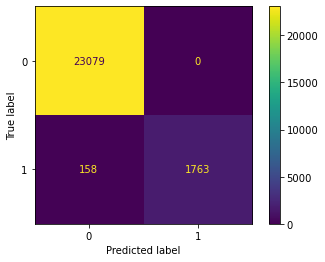

In [214]:
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)

[Text(0.8333333333333334, 0.9444444444444444, 'X[11] <= 0.5\ngini = 0.146\nsamples = 74999\nvalue = [69051, 5948]'),
 Text(0.75, 0.8333333333333334, 'X[5] <= 0.5\ngini = 0.07\nsamples = 71654\nvalue = [69051, 2603]'),
 Text(0.6666666666666666, 0.7222222222222222, 'X[3] <= 0.5\ngini = 0.031\nsamples = 70170\nvalue = [69051, 1119]'),
 Text(0.5833333333333334, 0.6111111111111112, 'X[1] <= 0.5\ngini = 0.025\nsamples = 69923\nvalue = [69051, 872]'),
 Text(0.5, 0.5, 'X[2] <= 0.5\ngini = 0.02\nsamples = 69750\nvalue = [69051, 699]'),
 Text(0.4166666666666667, 0.3888888888888889, 'X[7] <= 0.5\ngini = 0.016\nsamples = 69595\nvalue = [69051, 544]'),
 Text(0.3333333333333333, 0.2777777777777778, 'X[10] <= 0.5\ngini = 0.014\nsamples = 69544\nvalue = [69051, 493]'),
 Text(0.16666666666666666, 0.16666666666666666, 'X[0] <= 5.5\ngini = 0.001\nsamples = 6048\nvalue = [6046, 2]'),
 Text(0.08333333333333333, 0.05555555555555555, 'gini = 0.0\nsamples = 5393\nvalue = [5392, 1]'),
 Text(0.25, 0.05555555555

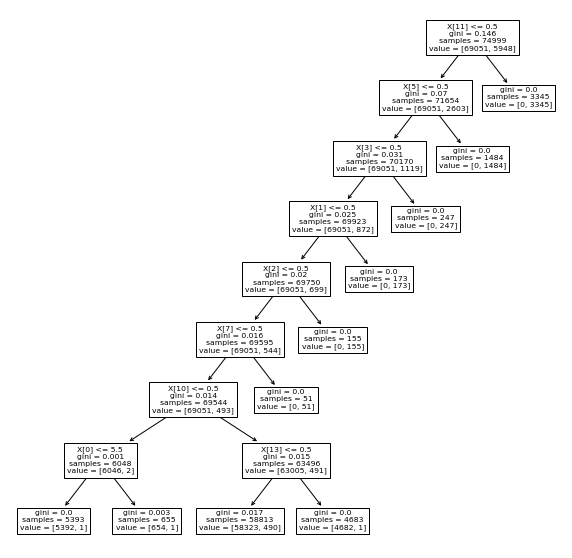

In [204]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(dt, ax=ax)

In [220]:
### Human label check 

samp_df_human = samp_df.sample(200, random_state=1234)

In [224]:
samp_df_human = samp_df_human.drop(['target_v2', 'target_v1'], axis=1)

In [223]:
#samp_df_human.to_csv('./data/samp_df_human.csv')

### Foundational NER Model ZeroShot just using 'person' and 'government' as the entities

In [ ]:
#Thinking about doing this zero-shot NER with custom label model
#!pip install gliner-spacy

In [ ]:
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from gliner_spacy.pipeline import GlinerSpacy

In [ ]:
## loaded the spacy model in the function above as 'nlp'

nlp.add_pipe("gliner_spacy", config={"labels": ['person', 'government' ]})

In [ ]:
samp_df['name'] = samp_df['name'].astype(str)

# Create an empty list to store the labels
labels_list = []

# Iterate over the 'text_column' using spaCy
for text in samp_df['name']:
    doc = nlp(text)
    # Process the text as needed
    # For example, store entities in each document
    labels = [ent.label_ for ent in doc.ents]
    #print(text,labels)
    labels_list.append(labels)

# Add the labels as a new column to the DataFrame
samp_df['zero_shot_labelsv1'] = labels_list

In [ ]:
### samp_df.to_csv('samp_df_zeroshot.csv', index=False)